In [3]:
!pip install PyYAML

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import cv2
import numpy as np
import os
import yaml
from yaml.loader import SafeLoader

In [26]:
# load YAML
with open('/content/drive/MyDrive/data.yaml',mode='r') as f:
    data_yaml = yaml.load(f,Loader=SafeLoader)

labels = data_yaml['names']
print(labels)

['trees', 'Devakanchan Tree', 'Neem Tree', 'Mango Tree']


In [27]:
# load YOLO model
yolo = cv2.dnn.readNetFromONNX('/content/drive/MyDrive/Yolo/yolov5/runs/train/Model2/weights/best.onnx')
yolo.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
yolo.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [28]:
# load the image
img = cv2.imread('/content/drive/MyDrive/data images/train/DJI_0146_JPG.rf.cba17a0304a36336222f15c9ae92e2a7.jpg')
image = img.copy()
row, col, d = image.shape


# get the YOLO prediction from the the image
# step-1 convert image into square image (array)
max_rc = max(row,col)
input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
input_image[0:row,0:col] = image
# step-2: get prediction from square array
INPUT_WH_YOLO = 640
blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WH_YOLO,INPUT_WH_YOLO),swapRB=True,crop=False)
yolo.setInput(blob)
preds = yolo.forward() # detection or prediction from YOLO

In [29]:
print(preds.shape)

(1, 25200, 9)


In [30]:
# Non Maximum Supression
# step-1: filter detection based on confidence (0.4) and probability score (0.25)
detections = preds[0]
boxes = []
confidences = []
classes = []

# widht and height of the image (input_image)
image_w, image_h = input_image.shape[:2]
x_factor = image_w/INPUT_WH_YOLO
y_factor = image_h/INPUT_WH_YOLO

for i in range(len(detections)):
    row = detections[i]
    confidence = row[4] # confidence of detection an object
    if confidence > 0.25:
        class_score = row[5:].max() # maximum probability from 20 objects
        class_id = row[5:].argmax() # get the index position at which max probabilty occur

        if class_score > 0.45:
            cx, cy, w, h = row[0:4]
            # construct bounding from four values
            # left, top, width and height
            left = int((cx - 0.5*w)*x_factor)
            top = int((cy - 0.5*h)*y_factor)
            width = int(w*x_factor)
            height = int(h*y_factor)

            box = np.array([left,top,width,height])

            # append values into the list
            confidences.append(confidence)
            boxes.append(box)
            classes.append(class_id)

# clean
boxes_np = np.array(boxes).tolist()
confidences_np = np.array(confidences).tolist()

# NMS
index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.45,0.75).flatten()


In [31]:
index

array([132, 149,  75,  42, 129, 116, 102,  87], dtype=int32)

In [32]:
# Draw the Bounding
for ind in index:
    # extract bounding box
    x,y,w,h = boxes_np[ind]
    bb_conf = int(confidences_np[ind]*100)
    classes_id = classes[ind]
    class_name = labels[classes_id]

    text = f'{class_name}'

    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.rectangle(image,(x,y-30),(x+w,y),(255,255,255),-1)

    cv2.putText(image,text,(x,y-10),cv2.FONT_HERSHEY_PLAIN,0.7,(0,0,0),1)



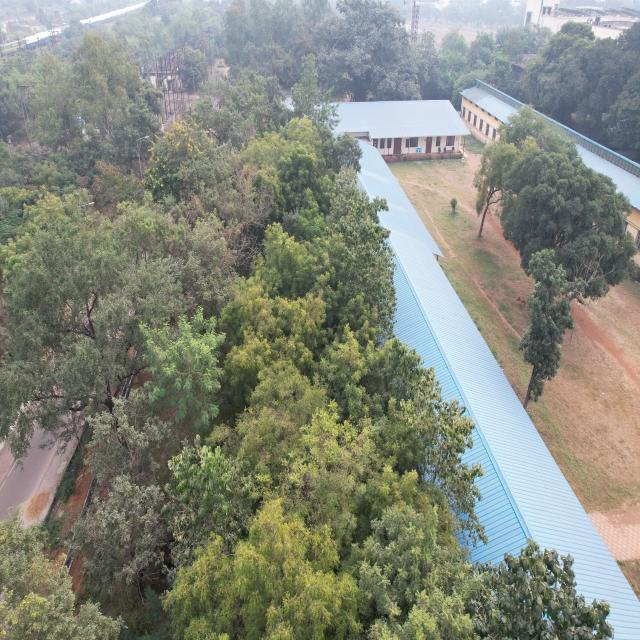

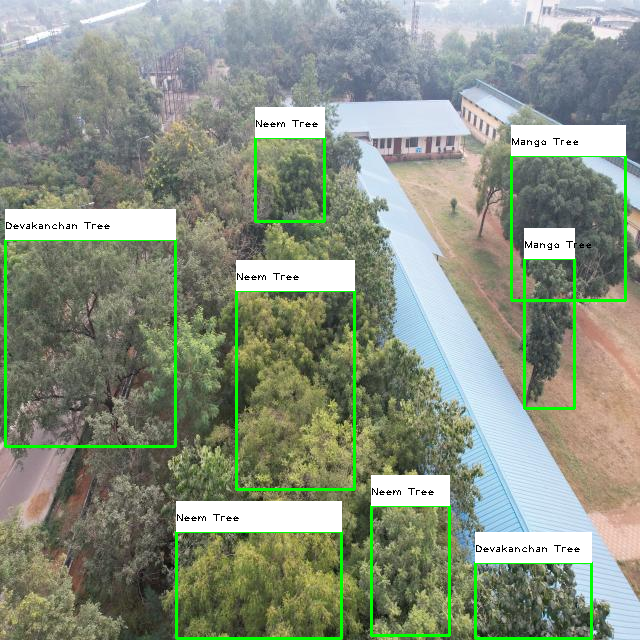

In [33]:
from google.colab.patches import cv2_imshow

# Show the original image
cv2_imshow(img)
# Show the YOLO prediction image
cv2_imshow(image)

# Wait for a key press and close the windows
cv2.waitKey(0)
cv2.destroyAllWindows()


In [34]:
import cv2
from collections import Counter

detections = []  # List to store detection details
class_counter = Counter()  # To count occurrences of each class

# Assume 'index', 'boxes_np', 'confidences_np', 'classes', and 'labels' are predefined
for ind in index:
    x, y, w, h = boxes_np[ind]
    confidence = confidences_np[ind]
    class_id = classes[ind]
    class_name = labels[class_id]

    # Update the class counter with the class name
    class_counter[class_name] += 1

    # Store detection details in a dictionary and append to the list
    detection = {
        "class_name": class_name,
        "bbox": (x, y, w, h),
        "confidence": confidence
    }
    detections.append(detection)

    # Draw bounding box and label on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.rectangle(image, (x, y - 30), (x + w, y), (255, 255, 255), -1)
    cv2.putText(image, f'{class_name} {int(confidence * 100)}%', (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 0.7, (0, 0, 0), 1)


# Print summary of detections
print("\nSummary of Detections:")
print(f"Total Detections: {sum(class_counter.values())}")
for class_name, count in class_counter.items():
    print(f"{class_name}: {count} Trees")


Summary of Detections:
Total Detections: 8
Neem Tree: 4 Trees
Mango Tree: 2 Trees
Devakanchan Tree: 2 Trees


In [48]:
# Oxygen production rates for each tree in units
oxy_rates = {'Neem': 450, 'Mango': 550, 'Devkanchan': 650}

# Calculate existing tree counts from some data source or input
class_counter = {'Neem Tree': 4, 'Devkanchan Tree': 2, 'Mango Tree': 2}
tree_count = {name.split(' ')[0]: count for name, count in class_counter.items()}

# Calculate total oxygen production from existing trees
total_oxygen_production = sum(oxy_rates.get(tree, 0) * count for tree, count in tree_count.items())

# User input for total population
n = int(input("Enter the total population: "))
total_oxygen_needed = n * 600  # Assuming each person needs 600 units of oxygen per day

# Check if the produced oxygen meets the population's needs
if total_oxygen_needed <= total_oxygen_production:
    print('Oxygen is sufficient.')
else:
    print('Oxygen is not sufficient.')
    oxygen_deficit = total_oxygen_needed - total_oxygen_production

    additional_trees_needed = {}
    remaining_deficit = oxygen_deficit

    # Sort trees based on their efficiency (oxygen production rate)
    sorted_trees = sorted(oxy_rates.items(), key=lambda item: item[1], reverse=True)

    # Evenly distribute the planting requirement across all tree types
    for tree, production in sorted_trees:
        if remaining_deficit <= 0:
            break
        # Calculate part of the deficit this tree type will address
        part_deficit = remaining_deficit // len(sorted_trees)
        trees_to_plant = (part_deficit + production - 1) // production
        additional_trees_needed[tree] = trees_to_plant
        remaining_deficit -= trees_to_plant * production

    # Check remaining deficit and adjust if necessary
    if remaining_deficit > 0:
        for tree, production in sorted_trees:
            if remaining_deficit <= 0:
                break
            extra_trees = (remaining_deficit + production - 1) // production
            additional_trees_needed[tree] += extra_trees
            remaining_deficit -= extra_trees * production

    # Output the results
    print("To meet the oxygen requirements, consider planting the following trees:")
    for tree, count_needed in additional_trees_needed.items():
        if count_needed > 0:
            print(f"{count_needed} more {tree} trees")

    # Verify if the new total oxygen production meets the required amount
    new_total_oxygen = total_oxygen_production + sum(oxy_rates.get(tree, 0) * count for tree, count in additional_trees_needed.items())
    if new_total_oxygen >= total_oxygen_needed:
        print("With the additional trees, the oxygen supply will be sufficient.")
    else:
        print("Even with the additional trees, the oxygen supply will still be insufficient.")

Enter the total population: 100
Oxygen is not sufficient.
To meet the oxygen requirements, consider planting the following trees:
54 more Devkanchan trees
23 more Mango trees
18 more Neem trees
With the additional trees, the oxygen supply will be sufficient.
